In [1]:
#%matplotlib inline
#%matplotlib gtk
import sys
sys.path.insert(0, '../')
from pytest import approx
import fconcrete as fc
#import fconcrete
#from fconcrete import helpers, duplicated, Material, e, Beam, Node, Loads, Nodes, Load,Material, ConcreteBeam, SingleBeamElement, Rectangle, Concrete, Section, ConcreteSteels
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=3000)

#from math import log

# Tension in MPa
# length in cm
# Shear in kN

In [6]:
material = fc.Concrete(fck='30 MPa', aggressiveness=2)
section = fc.Rectangle(25,56, material)

#Design
f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = fc.Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = fc.Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = fc.Node.SimpleSupport(x=0)
n2 = fc.Node.SimpleSupport(x=113)
n3 = fc.Node.SimpleSupport(x=583)
n4 = fc.Node.SimpleSupport(x=1188)

bar1 = fc.SingleBeamElement([n1, n2], section)
bar2 = fc.SingleBeamElement([n2, n3], section)
bar3 = fc.SingleBeamElement([n3, n4], section)

fc.config.available_material = {
    "concrete_steel_bars":fc.AvailableConcreteSteelBar(diameters=[8]),
    "steel_bar_surface_type":"ribbed"
}
    
beam = fc.ConcreteBeam(
    loads = [f1, f2, f3],
    beam_elements = [bar1, bar2, bar3],
    bar_steel_max_removal = 2,
)
self = beam
steel_bars = self.steel_bars

### Decaleged Behaviour

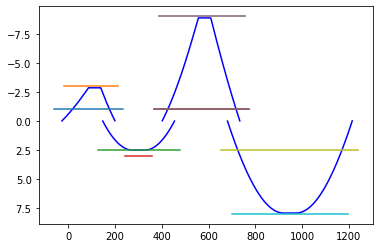

In [7]:
x, yp, yn = beam.getSteelAreaDiagram()
plt.plot(x, yp, 'b-')
plt.plot(x, yn, 'b-')
self.steel_bars.plot()

In [9]:
self.steel_bars.steel_bars

array([{'long_begin': -61.34513665021177, 'long_end': 236.15596451807966, 'quantity': 2, 'diameter': -0.8, 'interspace': (-26.49999, 200.63514131131132), 'quantity_accumulated': 2, 'area_accumulated': -1.0, 'area': -1.0, 'fyd': 43.47826086956522}
, {'long_begin': -17.34513739095251, 'long_end': 212.37218113469626, 'quantity': 4, 'diameter': -0.8, 'interspace': (-26.49999, 200.63514131131132), 'quantity_accumulated': 6, 'area_accumulated': -3.0, 'area': -2.0, 'fyd': 43.47826086956522}
, {'long_begin': 125.961943255516, 'long_end': 476.9569855132528, 'quantity': 5, 'diameter': 0.8, 'interspace': (147.79730525525525, 455.1216235135135), 'quantity_accumulated': 5, 'area_accumulated': 2.5, 'area': 2.5, 'fyd': 43.47826086956522}
, {'long_begin': 243.6916710032637, 'long_end': 358.88941948722675, 'quantity': 1, 'diameter': 0.8, 'interspace': (147.79730525525525, 455.1216235135135), 'quantity_accumulated': 6, 'area_accumulated': 3.0, 'area': 0.5, 'fyd': 43.47826086956522}
, {'long_begin': 365.

In [12]:
np.unique(self.steel_bars.steel_bars)

TypeError: '<' not supported between instances of 'SteelBar' and 'SteelBar'